In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.metrics

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
data = pd.read_csv('../notebooks/clean_df.csv')
data.head()

,Unnamed: 0,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,...,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY,Age Above 60?,Temp Groups,CORADS 6
0,0,1013,IGIB1040201013,IGIB1040201013-1,0.551724,1,0.436782,"fever, cough,breathlessness",1,1,...,0.127089,0.152271,sinus rhythm,normal,4.0,5a,No,0,0.2,0.0
1,1,1014,IGIB1040201014,IGIB1040201014-1,0.241379,0,0.804598,asymptomatic,0,0,...,0.172501,0.009346,sinus rhythm,normal,0.0,5b,No,0,0.6,0.0
2,2,1015,IGIB1040201015,IGIB1040201015-1,0.264368,1,0.402299,asymptomatic,0,0,...,0.259224,0.026437,sinus rhythm,normal,0.0,5b,No,0,0.4,0.0
3,3,1016,IGIB1040201016,IGIB1040201016-1,0.781609,1,0.321839,"fever, cough,breathlessness",1,1,...,0.366446,0.443161,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
4,4,1060,IGIB1040201060,IGIB1040201060-1,0.505747,1,1.000000,"fever,cough",1,1,...,0.546200,0.430297,sinus rhythm,normal,5.0,4,No,0,0.8,0.0


## Model

In [3]:
def model_perf(x,y,model):
    cm = metrics.confusion_matrix(y, model.predict(x))
    plt.figure
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.savefig('covidseverity.png')
    accuracy = model.score(x,y)
    precision,recall,f1,support = sklearn.metrics.precision_recall_fscore_support(y, model.predict(x),average='binary')
    print("Accuracy Score = ",accuracy)
    print("Precision Score = ",precision)    
    print("Recall Score = ",recall)    
    print("F1 Score = ",f1)

In [4]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [5]:
def visualize(x,y, model):
    
        cm = metrics.confusion_matrix(y, model.predict(x))
        plt.figure
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.savefig('covidseverity.png')
        
        
def ttmodel(X, Y, lm, n):
    
        train_accuracy = [0]*n
        train_precision = [0]*n
        train_recall = [0]*n
        train_f1 = [0]*n

        test_accuracy = [0]*n
        test_precision = [0]*n
        test_recall = [0]*n
        test_f1 = [0]*n
        
        for i in range(n):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

            lm.fit(x_train,y_train)

            train_accuracy[i] = lm.score(x_train,y_train)
            train_precision[i], train_recall[i], train_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_train, lm.predict(x_train), average='weighted')

            test_accuracy[i] = lm.score(x_test,y_test)
            test_precision[i], test_recall[i], test_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_test, lm.predict(x_test), average='weighted')

        print("Average training statistics over",n,"runs of the SVM model - ")
        print("Accuracy Score = ", sum(train_accuracy)/n)
        print("Precision Score = ", sum(train_precision)/n)    
        print("Recall Score = ", sum(train_recall)/n)   
        print("F1 Score = ", sum(train_f1)/n) 

        print()
        
        print("Average testing statistics over",n,"runs of the SVM model - ")
        print("Accuracy Score = ", sum(test_accuracy)/n)
        print("Precision Score = ", sum(test_precision)/n)    
        print("Recall Score = ", sum(test_recall)/n)   
        print("F1 Score = ", sum(test_f1)/n) 
        
        visualize(x_test, y_test, lm)
        
        
def cvmodel(X, Y, lm, cv):
    
        from sklearn.model_selection import cross_validate
        scoring = ['f1','roc_auc']
        scores = cross_validate(lm, X, Y, cv=cv, scoring = scoring, return_train_score=True)
        
        for k,v in scores.items():
            ans = [min(v),sum(v)/len(v),max(v)]
            print(k,"=",ans)
            print()

## Initial Factors + Symptoms and Comorbidities + Blood

In [6]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = data['Outcome']

trainset =  pd.read_csv('../notebooks/train.csv')
testset =  pd.read_csv('../notebooks/test.csv')

Xtrain = trainset[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
ytrain = trainset['Outcome']

Xtest = testset[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
ytest = testset['Outcome']

In [7]:
model = LogisticRegression(max_iter = 5000)
param_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
'penalty' : ['l2'],
'C' : [300, 100, 30, 10, 3, 1.0, 0.3, 0.1, 0.03, 0.01]} 

model, pred = algorithm_pipeline(Xtrain, Xtest, ytrain, ytest, model, 
                                 param_grid, cv=5, scoring_fit = 'f1')

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................C=300, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=300, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=300, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=300, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=300, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ....................C=300, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=300, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=300, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=300, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=300, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ................C=300, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=300, penalty=l2, sol

[CV] END ..................C=3, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=3, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........................C=3, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=3, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=3, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=3, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=3, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=3, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=3, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=3, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=3, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=3, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=1

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


Average training statistics over 100 runs of the SVM model - 
Accuracy Score =  0.9461832061068713
Precision Score =  0.9442872560914027
Recall Score =  0.9461832061068713
F1 Score =  0.9435728128703288

Average testing statistics over 100 runs of the SVM model - 
Accuracy Score =  0.9088636363636364
Precision Score =  0.9107676278080454
Recall Score =  0.9088636363636364
F1 Score =  0.9015474491159634


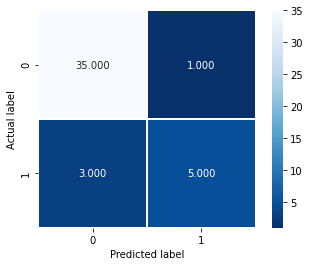

In [8]:
model = LogisticRegression(C = 10, penalty = 'l2', solver = 'newton-cg')
ttmodel(X, Y, model, 100)

In [9]:
cvmodel(X,Y,model,7)

fit_time = [0.008637189865112305, 0.009719439915248327, 0.012339591979980469]

score_time = [0.004574775695800781, 0.004718644278390067, 0.004860877990722656]

test_f1 = [0.3333333333333333, 0.6207482993197279, 0.8571428571428571]

train_f1 = [0.7222222222222223, 0.7834158270615267, 0.8947368421052632]

test_roc_auc = [0.8333333333333333, 0.9353741496598639, 1.0]

train_roc_auc = [0.9565384615384616, 0.9653427322031974, 0.9863418235511259]

